# OSMnx Tutorial

** This notebook introduces the OSMnx library created by Geoff Boeing, and is a montage and modest adaptation from demo notebooks he created, available here: https://github.com/gboeing/osmnx-examples**

OSMnx is a Python library that lets you download spatial geometries and construct, project, and visualize street networks from OpenStreetMap's API.

More about OSMnx: https://github.com/gboeing/osmnx

Install OSMnx: `pip install osmnx`

*Windows users*: install [geopandas](http://geoffboeing.com/2014/09/using-geopandas-windows/) and its dependencies (including rtree) first, before OSMnx

In [1]:
#!pip install osmnx

In [2]:
import osmnx as ox, geopandas as gpd, pandas as pd, numpy as np, networkx as nx, matplotlib.cm as cm
from shapely.geometry import Point
from descartes import PolygonPatch
import matplotlib.pylab as plt
%matplotlib inline
ox.config(log_console=True, use_cache=True)

## Get Boundary Polygons and Networks from OpenStreetMap

OSMnx lets you download spatial "place boundary" geometries from OpenStreetMap, save them to shapefiles, project them, and plot them. For a more in-depth demonstration of creating these shapefiles, see [OSMnx examples](https://github.com/gboeing/osmnx).

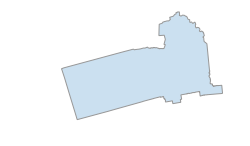

In [3]:
# get the boundary polygon for manhattan, save it as a shapefile, project it to UTM, and plot it
city = ox.gdf_from_place('Berkeley, California, USA')
ox.save_gdf_shapefile(city)
city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(3,3))

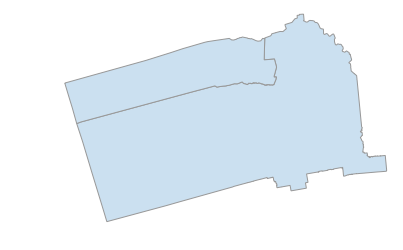

In [4]:
# get the boundary polygons for multiple cities, save as shapefile, project to UTM, and plot
place_names = ['Berkeley, California, USA', 
               'Albany, California, USA']
east_bay = ox.gdf_from_places(place_names)
ox.save_gdf_shapefile(east_bay)
east_bay = ox.project_gdf(east_bay)
fig, ax = ox.plot_shape(east_bay)

## Download and construct street networks

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, or shapefiles for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [OSMnx examples](https://github.com/gboeing/osmnx).

You can download a street network by providing OSMnx any of the following (demonstrated in the examples below):
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries

You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones

 #### Method #1, pass a bounding box ####
 This constructs the network from all the OSM nodes and ways within the bounding box.

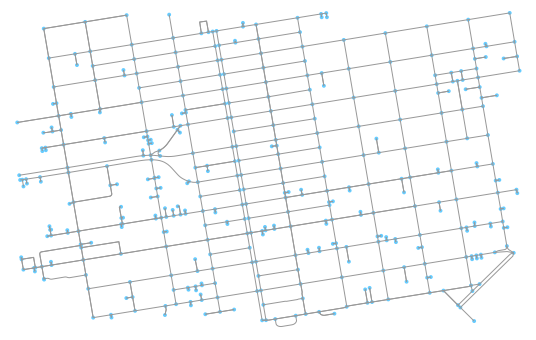

In [5]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
G1 = ox.project_graph(G1)
fig, ax = ox.plot_graph(G1)

#### Method #2, pass a lat-long point and bounding box distance in meters#### 
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

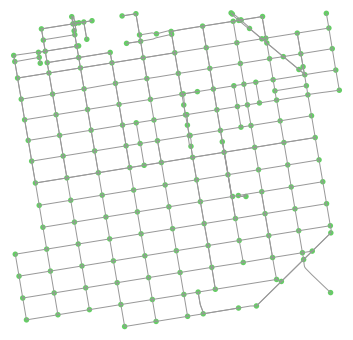

In [6]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G2 = ox.graph_from_point(location_point, distance=750, distance_type='bbox', network_type='drive')
G2 = ox.project_graph(G2)
fig, ax = ox.plot_graph(G2, node_size=30, node_color='#66cc66')

#### Method #3, pass a (lat,lon) point and *network* distance in meters ####

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it prunes the network by removing all nodes further than *n* meters from the point along the network.

By default, the `network_type` parameter value is 'all', meaning that we do not filter out paths that restrict certain types of traffic. This also means that one-way streets are honored as one-way and you cannot travel the wrong direction down them. Thus, the 500m takes into account only those nodes you can reach within 500m while only traveling in the allowed direction of the street. Instead (below), we can specify `network_type='walk'` to build a street network only of paths that walking is allowed on. This also makes every path bi-directional in the directed network, because you can walk in either direction on the sidewalk of a one-way street. Thus, the 500m now takes into account those nodes you can reach within 500m while traveling in either direction (even if it's a one-way street).

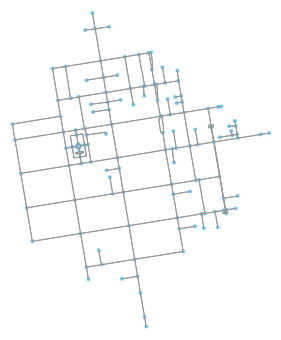

In [7]:
# create network only of nodes within 500m walking along the network from point
G3 = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='walk')
G3 = ox.project_graph(G3)
fig, ax = ox.plot_graph(G3)

#### Method #4, pass an address and distance (*bounding box* or *network*) in meters ####
This geocodes the address, creates a bounding box, downloads the network, then prunes it by network distance (if distance_type='network').

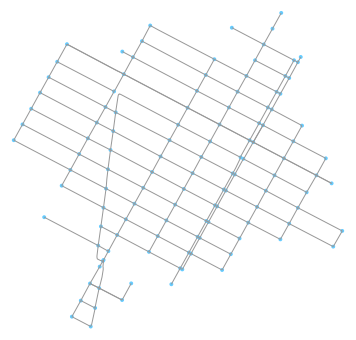

In [8]:
# network from address, including only nodes within 1km along the network from the address
G4 = ox.graph_from_address(address='350 5th Ave, New York, NY', 
                              distance=1000, distance_type='network', network_type='drive')

# you can project the network to UTM (zone calculated automatically)
G4_projected = ox.project_graph(G4)
fig, ax = ox.plot_graph(G4_projected)

#### Method #5, pass a place name ####

This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then prunes all nodes that lie outside the place's boundary polygon.

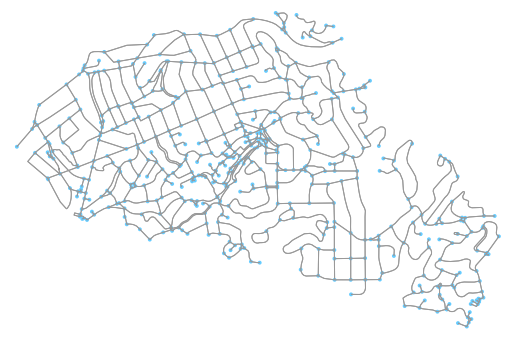

In [9]:
# create the street network within the city of Piedmont's borders
G5 = ox.graph_from_place('Piedmont, California, USA', network_type='walk')
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected)

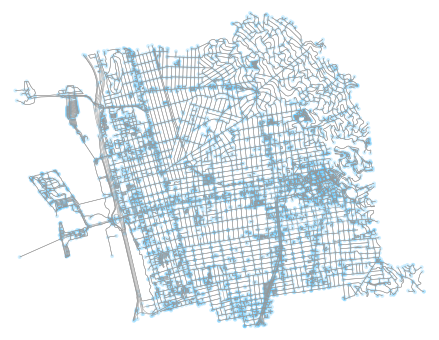

In [10]:
# you can also pass multiple places as a mixed list of strings and/or structured queries
place_names = ['Berkeley, California, USA', 
               'Albany, California, USA']
G5 = ox.graph_from_place(place_names, clean_periphery=False)
G5_projected = ox.project_graph(G5)
fig, ax = ox.plot_graph(G5_projected, fig_height=6, node_alpha=0.3, edge_linewidth=0.5)
ox.save_graph_shapefile(G5, filename='east-bay')

#### Method #6, pass a polygon ####

This example loads the [Mission District](http://www.zillow.com/howto/api/neighborhood-boundaries.htm)'s polygon from a shapefile, then downloads the network within its bounding box, then prunes all nodes that lie outside the place's boundary polygon.

In [13]:
calif = gpd.read_file('./ZillowNeighborhoods-CA.shp')
calif.head()

,STATE,COUNTY,CITY,NAME,REGIONID,geometry
0,CA,Alameda,Fremont,28 Palms,272706.0,"POLYGON ((-121.987571 37.5228600000001, -121.9..."
1,CA,Alameda,Fremont,Ardenwood,268001.0,"POLYGON ((-122.04133 37.56604, -122.04069 37.5..."
2,CA,Alameda,Fremont,Baylands,268017.0,"POLYGON ((-121.94596 37.4909100000001, -121.93..."
3,CA,Alameda,Fremont,Blacow,268026.0,"POLYGON ((-121.97197 37.52264, -121.97077 37.5..."
4,CA,Alameda,Fremont,Brookvale,268034.0,"(POLYGON ((-122.003900909091 37.5815036363638,..."


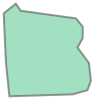

In [14]:
mission_district = calif[(calif['CITY']=='San Francisco') & (calif['NAME']=='Mission')]
polygon = mission_district['geometry'].iloc[0]
polygon

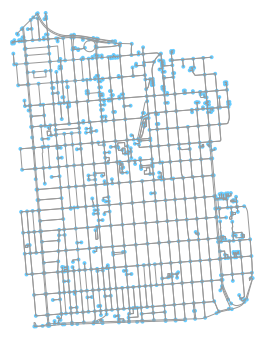

In [15]:
G6 = ox.graph_from_polygon(polygon, network_type='drive_service')
G6_projected = ox.project_graph(G6)
fig, ax = ox.plot_graph(G6_projected)

## Simplifying street network topology

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows simplification to an "expansion graph" (ie, if the graph were undirected, nodes with degree 2 as long as the incident edges have different OSM IDs). For a more in-depth demonstration of topological simplification with OSMnx, see [OSMnx examples](https://github.com/gboeing/osmnx).

In [16]:
# create a network around some (lat, lon) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, distance=500, simplify=False)

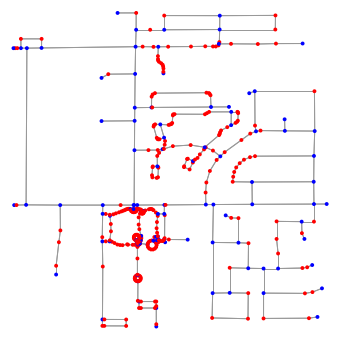

In [17]:
# turn off strict mode and see what nodes we'd remove, in red
nc = ['b' if ox.is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=3)

The red and blue dots above are OSM nodes. We'll remove the nodes in red as they're not real network nodes.

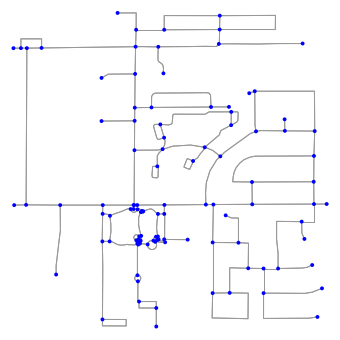

In [18]:
# simplify the network
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color='b', node_zorder=3)

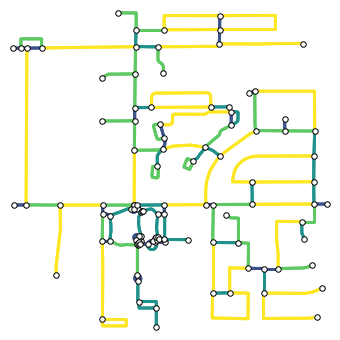

In [19]:
# show the simplified network with edges colored by edge length
ec = ox.get_edge_colors_by_attr(G, attr='length')
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color=ec, edge_linewidth=3)

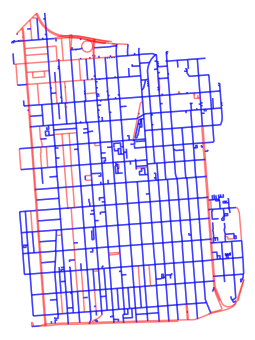

In [20]:
# highlight all the one-way edges in the mission district network from earlier
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G6.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G6, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

## Saving networks to disk

For more examples of saving and loading networks to/from disk, see [OSMnx examples](https://github.com/gboeing/osmnx).

In [21]:
# save street network as ESRI shapefile to work with in GIS
ox.save_graph_shapefile(G, filename='network-shape')

In [22]:
# save street network as GraphML file to work with in networkx or gephi
ox.save_graphml(G, filename='network.graphml')

In [23]:
# save street network as SVG to work with in Adobe Illustrator
fig, ax = ox.plot_graph(G, show=False, save=True, filename='network', file_format='svg')

In [24]:
# get one of each network type and save to disk as image and shapefile
for nt in ['all_private', 'all', 'bike', 'walk', 'drive', 'drive_service']:
    G = ox.graph_from_address('N Sicily Pl, Chandler, AZ', network_type=nt, distance=1500)
    filename = 'az-{}'.format(nt)
    fig, ax = ox.plot_graph(G, node_color='none', save=True, filename=filename, show=False)

For examples of working with these street networks in networkx, see [OSMnx examples](https://github.com/gboeing/osmnx).

## Calculate basic (and more advanced) street network metrics

In [25]:
# get the network for Piedmont, calculate its basic stats, then show the average circuity
stats = ox.basic_stats(ox.graph_from_place('Piedmont, California, USA', network_type='drive_service'))

In [26]:
stats

{'n': 406,
 'm': 1066,
 'k_avg': 5.251231527093596,
 'intersection_count': 348,
 'streets_per_node_avg': 2.8448275862068964,
 'streets_per_node_counts': {0: 0, 1: 58, 2: 2, 3: 294, 4: 50, 5: 1, 6: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.14285714285714285,
  2: 0.0049261083743842365,
  3: 0.7241379310344828,
  4: 0.12315270935960591,
  5: 0.0024630541871921183,
  6: 0.0024630541871921183},
 'edge_length_total': 119629.1429999998,
 'edge_length_avg': 112.22246060037506,
 'street_length_total': 62180.669,
 'street_length_avg': 112.03724144144144,
 'street_segments_count': 555,
 'node_density_km': None,
 'intersection_density_km': None,
 'edge_density_km': None,
 'street_density_km': None,
 'circuity_avg': 1.1142260525217895,
 'self_loop_proportion': 0.005628517823639775,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None}

### Statistics Documentation

Documentation on the various network graph statistics that OSMnx computes is available in the online docs:
http://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [27]:
stats['circuity_avg']

1.1142260525217895

To calculate density-based metrics, you must also pass the network's bounding area in square meters (otherwise `basic_stats()` will just skip them in the calculation):

In [28]:
# get the street network for a place, and its area in square meters (by projecting)
place = 'Piedmont, California, USA'
gdf = ox.gdf_from_place(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type='drive_service')

In [29]:
# calculate basic and extended network stats, merge them together, and display
stats = ox.basic_stats(G, area=area)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    stats[key] = value
pd.DataFrame(pd.Series(stats))

,0
n,406
m,1066
k_avg,5.25123
intersection_count,348
streets_per_node_avg,2.84483
streets_per_node_counts,"{0: 0, 1: 58, 2: 2, 3: 294, 4: 50, 5: 1, 6: 1}"
streets_per_node_proportion,"{0: 0.0, 1: 0.14285714285714285, 2: 0.00492610..."
edge_length_total,119629
edge_length_avg,112.222
street_length_total,62180.7


Notice that this returns the basic stats as a dict, which we threw into a pandas series. Degree counts and proportions are nested dicts inside it. To convert these stats to a pandas dataframe (to compare/analyze multiple networks against each other), just unpack these nested dicts first:

In [30]:
# unpack dicts into individiual keys:values
stats = ox.basic_stats(G, area=area)
for k, count in stats['streets_per_node_counts'].items():
    stats['int_{}_count'.format(k)] = count
for k, proportion in stats['streets_per_node_proportion'].items():
    stats['int_{}_prop'.format(k)] = proportion

# delete the no longer needed dict elements
del stats['streets_per_node_counts']
del stats['streets_per_node_proportion']

# load as a pandas dataframe
pd.DataFrame(pd.Series(stats)).T

,n,m,k_avg,intersection_count,streets_per_node_avg,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,...,int_4_count,int_5_count,int_6_count,int_0_prop,int_1_prop,int_2_prop,int_3_prop,int_4_prop,int_5_prop,int_6_prop
0,406.0,1066.0,5.251232,348.0,2.844828,119629.143,112.222461,62180.669,112.037241,555.0,...,50.0,1.0,1.0,0.0,0.142857,0.004926,0.724138,0.123153,0.002463,0.002463


In [31]:
# proportion of intersections that are cul-de-sacs, T-intersections, and X-intersections?
print(stats['int_1_prop'])
print(stats['int_3_prop'])
print(stats['int_4_prop'])

0.14285714285714285
0.7241379310344828
0.12315270935960591


In [32]:
# how many streets emanate from each intersection?
G.graph['streets_per_node']

{53090322: 3,
 53090323: 3,
 53068822: 3,
 53068826: 4,
 53142555: 3,
 53068829: 3,
 53021742: 4,
 53021743: 3,
 53144625: 3,
 317363251: 1,
 53021750: 3,
 53065783: 3,
 317297719: 3,
 53065785: 1,
 53089336: 3,
 53119042: 3,
 53127240: 3,
 703006798: 3,
 683050066: 1,
 53113943: 4,
 53113946: 4,
 53113947: 3,
 686202982: 3,
 697180263: 3,
 3695575152: 1,
 53097585: 3,
 53097586: 3,
 697180285: 3,
 683790465: 1,
 683050115: 3,
 53080198: 3,
 683050120: 3,
 260707479: 3,
 53152921: 1,
 260707482: 3,
 317295773: 3,
 53057697: 4,
 53057704: 3,
 53117097: 3,
 53117098: 3,
 256542898: 3,
 256340150: 1,
 683790519: 4,
 53119160: 4,
 53119162: 4,
 53119164: 5,
 53119166: 4,
 5477879999: 3,
 53119168: 4,
 53085375: 3,
 5477880002: 1,
 2890584258: 3,
 5477880004: 1,
 53085377: 4,
 53085380: 3,
 53085382: 3,
 5477880009: 1,
 53085385: 3,
 53137611: 3,
 53085387: 4,
 53085388: 4,
 53085389: 3,
 53126347: 3,
 3164026063: 1,
 53126350: 3,
 687156433: 3,
 3581678802: 3,
 3164026067: 3,
 683050194: 3

## What's inside a NetworkX graph?

In [33]:
# nodes
#G.nodes(data=True)

In [34]:
# edges
#G.edges(keys=True, data=True)

### Selecting and highlighting different types of nodes

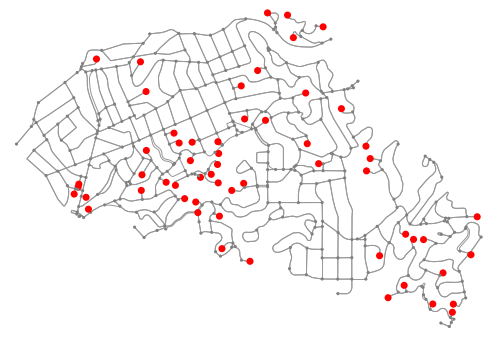

In [35]:
# highlight all the cul-de-sacs
nc = ['r' if G.graph['streets_per_node'][node]==1 else 'gray' for node in G.nodes()]
ns = [50 if G.graph['streets_per_node'][node]==1 else 10 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_zorder=2, node_size=ns)

### Betweenness Centrality

From wikipedia: In graph theory, betweenness centrality is a measure of centrality in a graph based on shortest paths. For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices such that either the number of edges that the path passes through (for unweighted graphs) or the sum of the weights of the edges (for weighted graphs) is minimized. The betweenness centrality for each vertex is the number of these shortest paths that pass through the vertex.

Betweenness centrality finds wide application in network theory: it represents the degree of which nodes stand between each other. For example, in a telecommunications network, a node with higher betweenness centrality would have more control over the network, because more information will pass through that node. Betweenness centrality was devised as a general measure of centrality:[1] it applies to a wide range of problems in network theory, including problems related to social networks, biology, transport and scientific cooperation.

Freeman, Linton (1977). "A set of measures of centrality based on betweenness". Sociometry. 40: 35–41. doi:10.2307/3033543

In [36]:
G_projected = ox.project_graph(G)
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

(53124805, 0.30728794311089913)

In the city of Piedmont, California, the node with the highest betweenness centrality has 30% of all shortest paths running through it. Let's highlight it in the plot:

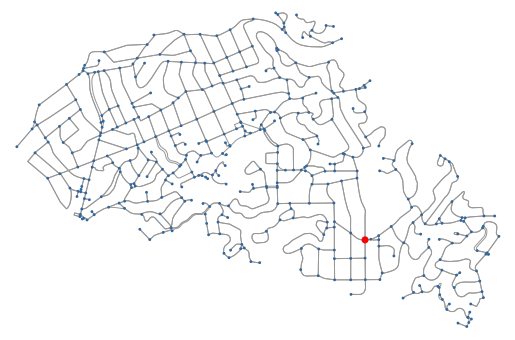

In [37]:
nc = ['r' if node==max_node else '#336699' for node in G_projected.nodes()]
ns = [50 if node==max_node else 8 for node in G_projected.nodes()]
fig, ax = ox.plot_graph(G_projected, node_size=ns, node_color=nc, node_zorder=2)

30% of all shortest paths run through the node highlighted in red. Let's look at the relative betweenness centrality of every node in the graph:

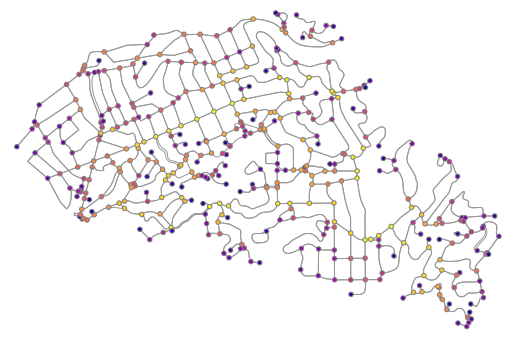

In [38]:
# get a color for each node
def get_color_list(n, color_map='plasma', start=0, end=1):
    return [cm.get_cmap(color_map)(x) for x in np.linspace(start, end, n)]

def get_node_colors_by_stat(G, data, start=0, end=1):
    df = pd.DataFrame(data=pd.Series(data).sort_values(), columns=['value'])
    df['colors'] = get_color_list(len(df), start=start, end=end)
    df = df.reindex(G.nodes())
    return df['colors'].tolist()

nc = get_node_colors_by_stat(G_projected, data=extended_stats['betweenness_centrality'])
fig, ax = ox.plot_graph(G_projected, node_color=nc, node_edgecolor='gray', node_size=20, node_zorder=2)

Above, the nodes are visualized by betweenness centrality, from low (dark violet) to high (light yellow).

## Routing: calculate the network path from the centermost node to some other node
Let the origin node be the node nearest the location and let the destination node just be the last node in the network. Then find the shortest path between origin and destination, using weight='length' to find the shortest spatial path (otherwise it treats each edge as weight=1).

In [39]:
# define a lat-long point, create network around point, define origin/destination nodes
location_point = (37.791427, -122.410018)
G = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='walk')
origin_node = ox.get_nearest_node(G, location_point)
destination_node = list(G.nodes())[-1]

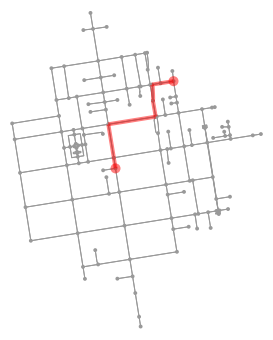

In [40]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)

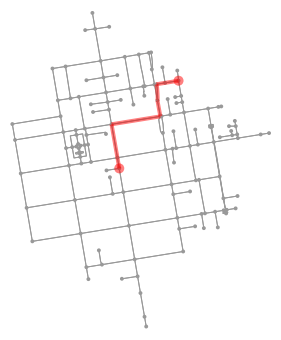

In [41]:
# project the network to UTM (zone calculated automatically) then plot the network/route again
G_proj = ox.project_graph(G)
fig, ax = ox.plot_graph_route(G_proj, route)

## Routing: plot network path from one lat-long to another

In [42]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

(850803362, 65290756)

In [43]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[850803362, 633686735, 633686762, 633686748, 633686743, 850803353, 65295320, 65295314, 65295311, 65332818, 65332815, 65319944, 65290756]'

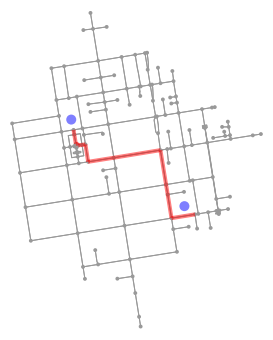

In [44]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)

## Demonstrate routing with one-way streets

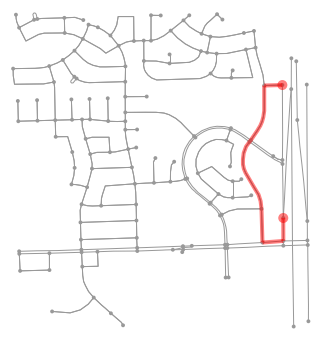

In [45]:
G = ox.graph_from_address('N. Sicily Pl., Chandler, Arizona', distance=800, network_type='drive')
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route, save=True, filename='route')

# Node elevations and edge grades

**You will need a Google Maps Elevation API key from https://developers.google.com/maps/documentation/elevation/start**

Go to this link and get one, and save it in keys.py where there is a placeholder for the key 

API usage limits: 50 requests per second, 2500 free requests per day, and 512 locations per request. So that's 2500 * 512 = 1.28 million total locations theoretically possible per day. But, the request URL is limited to 8192 characters, so OSMnx rounds coordinates to 5 decimal places (approx 1 meter) to fit 350 locations in a batch (thus ~875,000 nodes are possible per day).
  
Note that there is some spatial inaccuracy given Google's dataset's resolution. For example, in San Francisco (where the resolution is 19 meters) a couple of edges in hilly parks have a 50+ percent grade because Google assigns one of their nodes the elevation of a hill adjacent to the street.

In [46]:
from keys import google_elevation_api_key #replace this with your own API key
import osmnx as ox, networkx as nx, numpy as np
ox.config(log_console=True, use_cache=True)

In [47]:
# get the street network for san francisco
place = 'Berkeley, California'
G = ox.graph_from_place(place, network_type='drive')

In [48]:
# add elevation to each of the nodes, using the google elevation API, then calculate edge grades
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)
G = ox.add_edge_grades(G)

Exception: Graph has 2108 nodes but we received 0 results from the elevation API.

## Calculate some summary stats

Use an undirected representation of the network so we don't overcount two-way streets (because they have reciprocal edges pointing in each direction). We use the absolute value of edge grade because we're interested in steepness, not directionality.

In [ ]:
edge_grades = [data['grade_abs'] for u, v, k, data in ox.get_undirected(G).edges(keys=True, data=True)]

In [ ]:
avg_grade = np.mean(edge_grades)
print('Average street grade in {} is {:.1f}%'.format(place, avg_grade*100))

med_grade = np.median(edge_grades)
print('Median street grade in {} is {:.1f}%'.format(place, med_grade*100))

## Plot the nodes by elevation

Plot them colored from low (violet) to high (yellow).

In [ ]:
# project the street network to UTM
G_proj = ox.project_graph(G)

In [ ]:
# get one color for each node, by elevation, then plot the network
nc = ox.get_node_colors_by_attr(G_proj, 'elevation', cmap='plasma')
fig, ax = ox.plot_graph(G_proj, fig_height=6, node_color=nc, node_size=12, node_zorder=2, edge_color='#dddddd')

## Plot the edges by grade

Grade is the ratio of elevation change to edge length. Plot edges colored from low/flat (violet) to high/steep (yellow).

In [ ]:
# get a color for each edge, by grade, then plot the network
ec = ox.get_edge_colors_by_attr(G_proj, 'grade_abs', cmap='plasma', num_bins=100)
fig, ax = ox.plot_graph(G_proj, fig_height=6, edge_color=ec, edge_linewidth=0.8, node_size=0)

## Calculate shortest paths, considering grade impedance

This is my bike commute from Wurster home.

In [ ]:
# select an origin and destination node and a bounding box around them
origin = ox.get_nearest_node(G, (37.870553, -122.2547))
destination = ox.get_nearest_node(G, (37.8945948, -122.2712176))
bbox = ox.bbox_from_point((37.87, -122.2547), distance=3500, project_utm=True)

In [ ]:
# define some edge impedance function here
def impedance(length, grade):
    penalty = 1 + (grade * 100) 
    return length * penalty

# add impedance and elevation rise values to each edge in the projected graph
# use absolute value of grade in impedance function if you want to avoid uphill and downhill
for u, v, k, data in G_proj.edges(keys=True, data=True):
    data['impedance'] = impedance(data['length'], data['grade_abs'])
    data['rise'] = data['length'] * data['grade']

#### First find the shortest path that minimizes *trip distance*:

In [ ]:
route_by_length = nx.shortest_path(G_proj, source=origin, target=destination, weight='length')
fig, ax = ox.plot_graph_route(G_proj, route_by_length, bbox=bbox, node_size=0)

#### Now find the shortest path that avoids slopes by minimizing *impedance* (function of length and grade):


In [ ]:
route_by_impedance = nx.shortest_path(G_proj, source=origin, target=destination, weight='impedance')
fig, ax = ox.plot_graph_route(G_proj, route_by_impedance, bbox=bbox, node_size=0)

#### Print some summary stats about these two routes:

In [ ]:
def print_route_stats(route):
    route_grades = ox.get_route_edge_attributes(G_proj, route, 'grade_abs')
    msg = 'The average grade is {:.1f}% and the max is {:.1f}%'
    print(msg.format(np.mean(route_grades)*100, np.max(route_grades)*100))

    route_rises = ox.get_route_edge_attributes(G_proj, route, 'rise')
    ascent = np.sum([rise for rise in route_rises if rise >= 0])
    descent = np.sum([rise for rise in route_rises if rise < 0])
    msg = 'Total elevation change is {:.0f} meters: a {:.0f} meter ascent and a {:.0f} meter descent'
    print(msg.format(np.sum(route_rises), ascent, abs(descent)))

    route_lengths = ox.get_route_edge_attributes(G_proj, route, 'length')
    print('Total trip distance: {:,.0f} meters'.format(np.sum(route_lengths)))

In [ ]:
# stats of route minimizing length
print_route_stats(route_by_length)

In [ ]:
# stats of route minimizing impedance (function of length and grade)
print_route_stats(route_by_impedance)

So, we decreased the average slope along the route from a 4.6% grade to a 2.7% grade, but the trip length went up from 4,838 to 5,248 meters.

## Drawing Isochrone Maps

In [ ]:
# configure the place, network type, trip times, and travel speed
place = 'Berkeley, CA, USA'
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [ ]:
# download the street network
G = ox.graph_from_place(place, network_type=network_type)

In [ ]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

In [ ]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [ ]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

In [ ]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'gray' for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=20, node_alpha=0.8, node_zorder=2)


In [ ]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

In [ ]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()


## Your Turn:

Try selecting another city (preferably not a huge one) - say El Cerrito or Richmond for example, and re-do the network analysis with and without considering elevation. Select your own points for origin and destination for this.

Experiment with the penalty function that adds a penalty for steeper grades.

Create isochrone walking maps for your selected city.